> This notebook requires the extended crossover graph, for example, the one constructed by 2024-03-26-extended-cx-graph.ipynb
> The asset package should include a ready-made graph here.

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import igraph as ig
from pathlib import Path

In [2]:
import rpy2
# Configure for notebook use.
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
%load_ext rpy2.ipython

# Loading

In [47]:
# task = "imagenet (a)"
# task = "imagenet (b)"
task = "segmentation"
spacing = 1_000

c0 = "accuracy"
c1 = "multiply-adds"

In [48]:
def davuag_process_edge(graph, genotype, e):
    """
    Determine whether an edge e is (potentially) used according to the annotated graph, using
    the given genotype.

    Used in determine_active_variables_using_annot_graph
    """
    target_vertex = graph.vs[e.target]
    related_genotype_pos = target_vertex["genotype_index"]
    # Keep edges for edge cases (they are not impacted)
    if related_genotype_pos is None or not np.isfinite(related_genotype_pos): return True
    assert (related_genotype_pos is not None) or target_vertex["module"] < 0, "Output should not have a genotype position"
    related_genotype_pos = int(related_genotype_pos)
    # Keep edges where socket matches (remove otherwise)
    return genotype[related_genotype_pos] == e["socket"]

def determine_active_variables_using_annot_graph(graph, genotype):
    """
    Given an annotated cx graph (e.g. generated by get_annotated_cx_connectivity_graph), determine the set of
    variables which are active - i.e. those which upon a change without changes to other variables will affect
    the output of the network.
    """
    graph_b = graph.copy()
    graph_b.delete_edges((~np.array([davuag_process_edge(graph, genotype, e) for e in graph.es])).nonzero()[0])
    active_vertices = graph_b.subcomponent(np.array([a == -1 for a in graph_b.vs["module"]]).nonzero()[0][0], mode='in')
    active_variables = np.unique([int(a) for a in graph_b.vs[active_vertices]["genotype_index"] if a is not None and np.isfinite(a)])
    return active_variables

In [49]:
# General 'knowledge'
improvement_direction = {
    "accuracy": 1,
    "loss": -1,
    "loss-clip": -1,
    "total bytes": -1,
    "total_memory_bytes": -1, # dict name
    "multiply-adds": -1,
    "total_mult_adds": -1, # dict name
    # "genotype": 0, # -- not a criterion
}
best_possible_value = {
    "accuracy": 1.0,
    "loss": 0.0,
    "loss-clip": 0.0,
    "total bytes": 0.0,
    "total_memory_bytes": 0.0,
    "multiply-adds": 0.0,
    "total_mult_adds": 0.0, 
}

# Task specific settings
if task == "imagenet (a)":
    # imagenet-a
    folder = Path("./2024-01-02-results/imagenet_a/")
    assert folder.exists()
    run_folder = folder / "exp-imagenet-a"
    assert run_folder.exists()
    files = list(run_folder.glob("*.arrow"))
    reference_file = folder / "stitched-imagenet-a-reference.arrow"
    # some task-specific tidbits
    min_accuracy = 0.7
    best_possible_value["accuracy"] = 0.8
    acxg = ig.Graph.Read_GraphMLz("stitched-imagenet-a-resnet152-b-efficientnet-b4-stitchgraph.graphmlz")
elif task == "imagenet (b)":
    # imagenet-b
    folder = Path("./2024-01-04")
    assert folder.exists()
    run_folder = folder / "exp-imagenet-b"
    assert run_folder.exists()
    files = list(run_folder.glob("*.arrow"))
    reference_file = folder / "stitched-imagenet-b-a-resnet50-b-resnext50_32x4d-reference.arrow"
    # some task-specific tidbits
    min_accuracy = 0.7
    best_possible_value["accuracy"] = 0.8
    acxg = ig.Graph.Read_GraphMLz("stitched-imagenet-b-a-resnet50-b-resnext50_32x4d-stitchgraph.graphmlz")

elif task == "segmentation":
    folder = Path("./2024-01-02-results/segmentation/")
    assert folder.exists()
    run_folder = folder / "exp-voc"
    assert run_folder.exists()
    files = list(run_folder.glob("*.arrow"))
    reference_file = folder / "stitched-voc-reference.arrow"
    # some task-specific tidbits
    min_accuracy = 0.90
    acxg = ig.Graph.Read_GraphMLz("stitched-voc-a-deeplab-mobilenetv3-b-deeplab-resnet50-stitchgraph.graphmlz")

else:
    raise ValueError("Unknown task")

if c0 == "accuracy":
    min_performance = min_accuracy

In [50]:
# Load reference front
reference_samples = pl.read_ipc(reference_file).rename({
    "total_memory_bytes": "total bytes",
    "total_mult_adds": "multiply-adds",
}).with_columns(
    pl.col("genotype").list.last().replace({
        0: "a",
        1: "b",
        2: "ensemble",
    }).alias("set"),
    pl.lit(reference_file.name).alias("file")
)

# Collect some statistics
run_info = []
common_columns = None

def load_run(filepath):
    global run_info
    global common_columns
    # As grouping label - use the file path - which is unique across any run.
    file_ref = filepath.name

    # Determine legend label - i.e. the approach used
    set_name = "unk"
    filepath_split = Path(filepath).name.split("-")
    if len(filepath_split) > 2:
        set_name = filepath_split[1]

    # Load data - note: here we always assume the files have already been converted to arrow
    # e.g. using jsonl-to-arrow.py.
    approach_samples = pl.read_ipc(filepath).lazy().with_row_count(name="#eval")
    num_samples_evaluated = approach_samples.select(pl.count()).collect().item()

    # Clean-up data
    approach_samples = approach_samples.drop_nulls("loss").rename({
        "total_memory_bytes": "total bytes",
        "total_mult_adds": "multiply-adds",
    }).with_columns([
        pl.lit(set_name).alias("set"),
        pl.lit(file_ref).alias("file"),
    ])
    num_samples_evaluated_active = approach_samples.select(pl.count()).collect().item()
    num_samples_evaluated_inactive = num_samples_evaluated - num_samples_evaluated_active

    # Collect data on how many evaluations were short-circuited.
    run_info.append({
        "file_ref": file_ref,
        "set_name": set_name,
        "num_samples_evaluated": num_samples_evaluated,
        "num_samples_evaluated_active": num_samples_evaluated_active,
        "num_samples_evaluated_inactive": num_samples_evaluated_inactive,
    })

    common_columns = list(set(approach_samples.columns).intersection(reference_samples.columns + ["#eval"]))
    approach_samples = approach_samples.select(common_columns)

    if min_performance is not None:
        approach_samples = approach_samples.filter(improvement_direction[c0] * pl.col(c0) > improvement_direction[c0] * min_performance)

    return approach_samples

runs_data = pl.concat(load_run(f) for f in files)


In [51]:
# count nonzero - active only!
def get_active_variables(genotype):
    return list(determine_active_variables_using_annot_graph(acxg, list(genotype)))
def sign_flip_inactive_variables(genotype):
    garr = np.array(genotype)
    active_vars = determine_active_variables_using_annot_graph(acxg, garr)
    for v in active_vars:
        garr[v] *= -1
    return list(-garr)

runs_data_l = (runs_data.filter(pl.col("set") != "RS")
# Subsample to reduce number of points for which inactive variables needs to be determined - 
# This turns out to be quite slow!
.filter((pl.col("#eval") // spacing) % 5 == 0)
.filter((pl.col("#eval")) % 50 == 0
).with_columns(
    pl.col("genotype").map_elements(sign_flip_inactive_variables, return_dtype=pl.List(int)).alias("active"),
    pl.col("set").replace({"LK_GOMEA": "LK-GOMEA", "SGA": "GA"})
).select([
    pl.col(["set", "file"]),
    (pl.col("#eval") // spacing).alias("eb"),
    pl.col("genotype"),
    pl.col("genotype").list.eval(pl.element() != 0).list.mean().alias("# nonzero"),
    pl.col("genotype").list.eval(pl.element() != 0).list.sum().alias("# nonzero count"),
    pl.col("active").list.eval(pl.max_horizontal(pl.element(), 0) != 0).list.mean().alias("# nonzero active"),
    pl.col("active").list.eval(pl.max_horizontal(pl.element(), 0) != 0).list.sum().alias("# nonzero active count"),
]).group_by(["set", "file", "eb"]).agg(
    pl.col("# nonzero").mean(),
    pl.col("# nonzero active").mean(),
    pl.col("# nonzero count").mean(),
    pl.col("# nonzero active count").mean(),
    
    )).collect()
runs_data_l

set,file,eb,# nonzero,# nonzero active,# nonzero count,# nonzero active count
str,str,u32,f64,f64,f64,f64
"""GA""","""es-SGA-voc-s56…",10,0.084071,0.003872,9.5,0.4375
"""GA""","""es-SGA-voc-s56…",15,0.119469,0.039086,13.5,4.416667
"""GA""","""es-SGA-voc-s56…",130,0.309735,0.040225,35.0,4.545455
"""GA""","""es-SGA-voc-s56…",140,0.338938,0.030973,38.3,3.5
"""GA""","""es-SGA-voc-s56…",170,0.347736,0.035398,39.294118,4.0
"""GA""","""es-SGA-voc-s56…",185,0.372946,0.029709,42.142857,3.357143
"""GOMEA""","""es-GOMEA-voc-s…",80,0.035398,0.017699,4.0,2.0
"""GOMEA""","""es-GOMEA-voc-s…",155,0.129794,0.070796,14.666667,8.0
"""GA""","""es-SGA-voc-s53…",50,0.218825,0.037812,24.727273,4.272727


In [52]:
task_fn = task.replace(" ", "-").replace("(", "").replace(")", "")
task_fn

'segmentation'

In [53]:
from matplotlib.cm import get_cmap
cm = get_cmap("Set1").colors

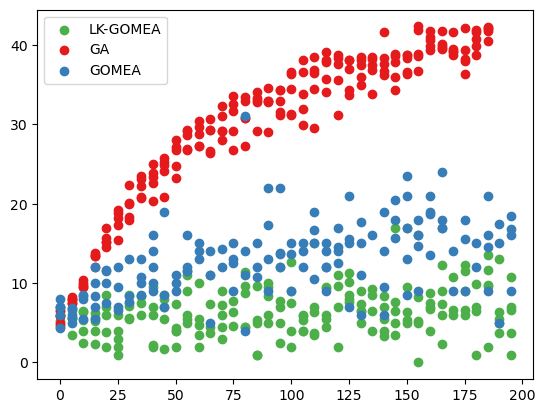

In [54]:
fig, ax = plt.subplots()
dcm = dict(zip(runs_data_l["set"].unique(maintain_order=True), cm))
for (c_set, ), r in runs_data_l.sort("eb").group_by(["set"]):
    ax.scatter(r["eb"], r["# nonzero count"], color=dcm[c_set], label=c_set)
ax.legend()

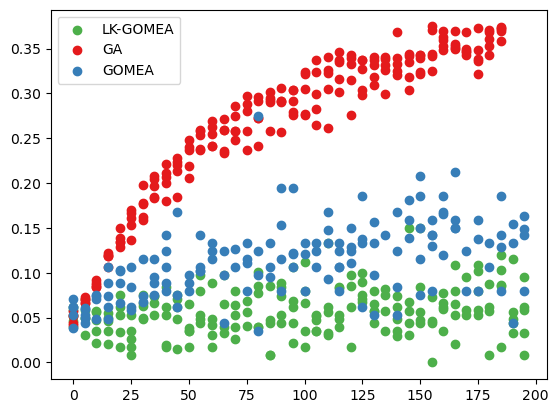

In [55]:
fig, ax = plt.subplots()
dcm = dict(zip(runs_data_l["set"].unique(maintain_order=True), cm))
for (c_set, ), r in runs_data_l.sort("eb").group_by(["set"]):
    ax.scatter(r["eb"], r["# nonzero"], color=dcm[c_set], label=c_set)
ax.legend()

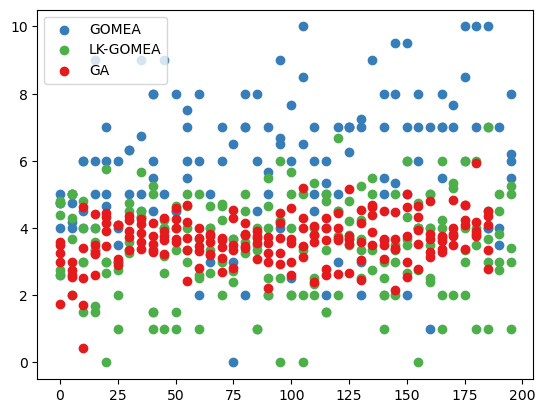

In [56]:
fig, ax = plt.subplots()
dcm = dict(zip(runs_data_l["set"].unique(maintain_order=True), cm))
for (c_set, ), r in runs_data_l.sort("eb").group_by(["set"]):
    ax.scatter(r["eb"], r["# nonzero active count"], color=dcm[c_set], label=c_set)
ax.legend()

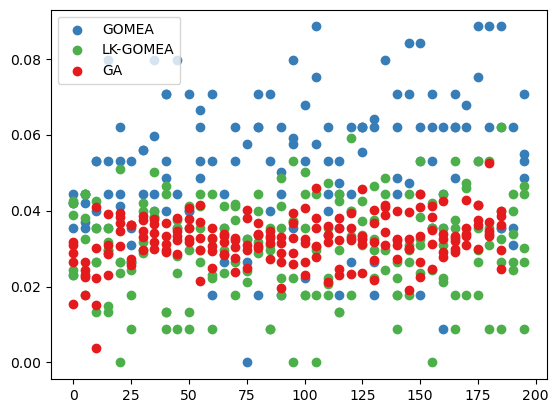

In [57]:
fig, ax = plt.subplots()
dcm = dict(zip(runs_data_l["set"].unique(maintain_order=True), cm))
for (c_set, ), r in runs_data_l.sort("eb").group_by(["set"]):
    ax.scatter(r["eb"], r["# nonzero active"], color=dcm[c_set], label=c_set)
ax.legend()

In [58]:
rdlpd = runs_data_l.with_columns(pl.col("eb").cast(pl.Int32)).to_pandas()
plot_filename = f"active-stitch-count-{task_fn}.pdf"
plot_filename

'active-stitch-count-segmentation.pdf'

In [59]:
%%R
library(ggplot2)
library(tidyverse)

Saving 4.86 x 3.47 in image


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


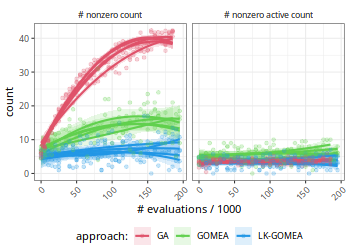

In [60]:
%%R -i rdlpd -i plot_filename -w 350 -h 250

pal <- palette("r4")[c(2, 3, 4)]
typed_factor_levels_color <- function() {
    ggplot2:::manual_scale(
        'color', 
        values = setNames(pal, c("GA", "GOMEA", "LK-GOMEA")),
        drop = FALSE
    ) 
}
    
typed_factor_levels_fill <- function() {
    ggplot2:::manual_scale(
        'fill', 
        values = setNames(pal, c("GA", "GOMEA", "LK-GOMEA")),
        drop = FALSE,
    )
}


plt <- rdlpd |>
    pivot_longer(cols=c(`# nonzero count`, `# nonzero active count`),
    names_to = "kind",
    values_to = "count"
    ) |> 
    mutate(kind = factor(kind, levels = c("# nonzero count", "# nonzero active count") ),
           set = factor(set, levels = c("GA", "GOMEA", "LK-GOMEA") )) |>
    ggplot(aes(x=`eb`, y=`count`, color=`set`, fill=`set`, group=`file`)) +
    # geom_line() +
    geom_smooth(alpha=0.15, span = 5) +
    geom_point(alpha=0.25) +
#     scale_color_manual(values=pal) +
    typed_factor_levels_color() +
    typed_factor_levels_fill() +
    facet_grid(. ~ `kind`) +
    labs(x = "# evaluations / 1000", color="approach:", fill="approach:") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank(),
    #   legend.title=element_blank(),
      legend.margin = margin(0, 0, 0, 0),
      legend.spacing.x = unit(2, "mm"),
      legend.spacing.y = unit(1, "mm"))
ggsave(plot_filename, device = cairo_pdf)
plt

In [46]:
%%R
plt_ima <- plt

In [31]:
%%R
plt_imb <- plt

In [61]:
%%R
plt_voc <- plt

In [62]:
%%R
library(patchwork)

Saving 11.1 x 3.47 in image
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


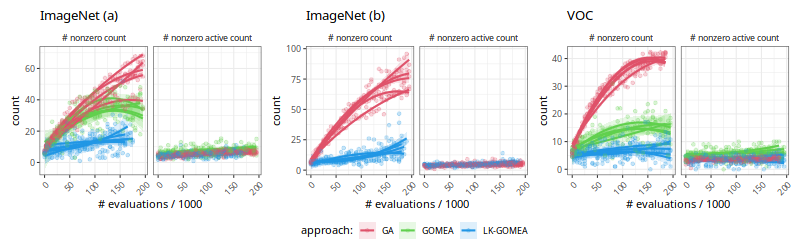

In [63]:
%%R -w 800 -h 250
plt_combined <- (plt_ima + labs(title="ImageNet (a)") | plt_imb + labs(title="ImageNet (b)") | plt_voc + labs(title="VOC") ) + plot_layout(guides = "collect") & theme(legend.position="bottom")
ggsave("active-stitch-count-all.pdf", device = cairo_pdf)
plt_combined

In [158]:
run_info = pl.DataFrame(run_info)

# Generic data

In [159]:
# Compute some preliminary statistics:
# - How much of the budget is used?
# - How often is the inactive variable short-circuit activated?

run_info.lazy().with_columns(
    (pl.col("num_samples_evaluated_active") / pl.col("num_samples_evaluated")).alias("num_samples_evaluated_active_ratio")
).group_by("set_name").agg([
    pl.col("^num_samples.*$").median().name.map(lambda x: x + "_median"),
    pl.col("^num_samples.*$").quantile(0.20).name.map(lambda x: x + "_q20"),
    pl.col("^num_samples.*$").quantile(0.80).name.map(lambda x: x + "_q80"),
]).sort("set_name").collect()

set_name,num_samples_evaluated_median,num_samples_evaluated_active_median,num_samples_evaluated_inactive_median,num_samples_evaluated_active_ratio_median,num_samples_evaluated_q20,num_samples_evaluated_active_q20,num_samples_evaluated_inactive_q20,num_samples_evaluated_active_ratio_q20,num_samples_evaluated_q80,num_samples_evaluated_active_q80,num_samples_evaluated_inactive_q80,num_samples_evaluated_active_ratio_q80
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""GOMEA""",200000.0,113959.0,86041.0,0.569795,200000.0,113948.0,85533.0,0.56974,200000.0,114467.0,86052.0,0.572335
"""LK_GOMEA""",200000.0,120571.0,79429.0,0.602855,200000.0,119783.0,79150.0,0.598915,200000.0,120850.0,80217.0,0.60425
"""RS""",174545.0,174545.0,0.0,1.0,171821.0,171821.0,0.0,1.0,176695.0,176695.0,0.0,1.0
"""SGA""",186668.0,186668.0,0.0,1.0,186650.0,186650.0,0.0,1.0,186885.0,186885.0,0.0,1.0
